In [21]:
# import warnings
# warnings.filterwarnings('ignore')

import os
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Technical Analysis
from talib import RSI, BBANDS, ATR, NATR, MACD

# scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# neural network
from tqdm import tqdm
import torch
import torch.nn as nn
  # our model
from LSTM import LSTM

# Data Preprocessing

In [2]:
# def read_tickers_sp500(file_path):
#     with open(file_path, 'r') as file:
#         tickers_sp500 = [line.strip() for line in file]
#     return tickers_sp500

# tickers_sp500 = read_tickers_sp500('tickers_sp500.txt')
# print(tickers_sp500)

In [3]:
# Download data

# Stocks list
# top 7 MarketCap in S&P500(^GSPC)
tickers = ['^GSPC', 'AAPL', 'MSFT', 'AMZN', 'NVDA', 'GOOGL', 'TSLA', 'META']
# tickers = tickers_sp500
start_date = None
end_date = None

df_prices_download = yf.download(tickers=tickers, start=start_date, end=end_date, group_by='ticker')

[*********************100%%**********************]  8 of 8 completed


In [4]:
# Format into large table
# col: OHLCV
# rows(multi-index): Ticker, Date

df_prices = df_prices_download.stack(level=0, dropna=False)
df_prices = df_prices.swaplevel(0, 1)
df_prices = df_prices.loc[tickers].sort_index(level='Ticker')
df_prices.dropna(inplace=True)

# Use 'Adj Close' instead of 'Close'
df_prices.drop('Close', axis=1, inplace=True)
df_prices.rename(columns={'Adj Close': 'Close'}, inplace=True)

df_prices

/var/folders/m6/fz_qjnl51s70hy69d_st2z240000gn/T/ipykernel_59389/4093512458.py:5: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df_prices = df_prices_download.stack(level=0, dropna=False)


Price                     Open         High          Low        Close  \
Ticker Date                                                             
AAPL   1980-12-12     0.128348     0.128906     0.128348     0.099192   
       1980-12-15     0.122210     0.122210     0.121652     0.094017   
       1980-12-16     0.113281     0.113281     0.112723     0.087117   
       1980-12-17     0.115513     0.116071     0.115513     0.089273   
       1980-12-18     0.118862     0.119420     0.118862     0.091861   
...                        ...          ...          ...          ...   
^GSPC  2024-05-03  5122.779785  5139.120117  5101.220215  5127.790039   
       2024-05-06  5142.419922  5181.000000  5142.419922  5180.740234   
       2024-05-07  5187.200195  5200.229980  5178.959961  5187.700195   
       2024-05-08  5168.979980  5191.950195  5165.859863  5187.669922   
       2024-05-09  5189.029785  5215.299805  5180.410156  5214.080078   

Price                    Volume  
Ticker Date                      
AAPL   1980-12-12  4.690336e+08  
       1980-12-15  1.758848e+08  
       1980-12-16  1.057280e+08  
       1980-12-17  8.644160e+07  
       1980-12-18  7.344960e+07  
...                         ...  
^GSPC  2024-05-03  3.924990e+09  
       2024-05-06  3.683250e+09  
       2024-05-07  3.987890e+09  
       2024-05-08  3.842100e+09  
       2024-05-09  3.727370e+09  

[69390 rows x 5 columns]

### Remove stocks with less than 10 years of data

In [5]:
min_obs_days = 10 * 252 # NYSE and NASDAQ average 252 trading days a year
num_obs = df_prices.groupby(level='Ticker').size()

tickers_to_drop = num_obs[num_obs < min_obs_days].index
print(f'Amount tickers_to_drop: {tickers_to_drop.size}')

df_prices.drop(tickers_to_drop, level='Ticker', inplace=True)

Amount tickers_to_drop: 0


# Feature Engineering

### RSI - Relative Strength Index
RSI compares the magnitude of recent price changes across stocks to identify stocks as overbought or oversold.

In [6]:
rsi = df_prices.groupby(level='Ticker', group_keys=False).Close.apply(RSI)
df_prices['RSI'] = rsi

### Bollinger Bands
Bollinger Bands is a technical analysis tool used to determine where prices are high and low relative to each other.

In [7]:
def compute_bb(close):
    high, mid, low = BBANDS(np.log1p(close), timeperiod=20)
    return pd.DataFrame({'BB_High': high,
                         'BB_Mid': mid, # SMA20
                         'BB_Low': low},
                        index=close.index)

bbands = df_prices.groupby(level='Ticker', group_keys=False).Close.apply(compute_bb)
df_prices = pd.concat([df_prices, bbands], axis=1)

### ATR - Average True Range
The average true range (ATR) indicator shows the volatility of the market.

In [8]:
by_ticker = df_prices.groupby('Ticker', group_keys=False)

def compute_atr(stock_data):
    atr = ATR(stock_data.High,
              stock_data.Low,
              stock_data.Close,
              timeperiod=14)
    return atr.sub(atr.mean()).div(atr.std())

df_prices['ATR'] = by_ticker.apply(compute_atr)
# Normalized Average True Range (NATR)
df_prices['NATR'] = by_ticker.apply(lambda x: NATR(high=x.High, low=x.Low, close=x.Close))

### MACD - Moving Average Convergence/Divergence

In [9]:
def compute_macd(close):
    macd = MACD(close)[0]
    return macd.sub(macd.mean()).div(macd.std())

df_prices['MACD'] = df_prices.groupby(level='Ticker', group_keys=False).Close.apply(compute_macd)

## Determine Investment Universe

### Dollar Volume

In [10]:
# Close: USD
# Volumn: Amount
df_prices['Dollar_Volume'] = (df_prices.loc[:, 'Close']
                           .mul(df_prices.loc[:, 'Volume'], axis=0))

df_prices.Dollar_Volume /= 1e6 # Dollar_Volume: Million USD

### Resample Monthly Freq.
- drop OHL_V
- use Dollar_Volumn instead of Volume

In [11]:
remian_cols = [c for c in df_prices.columns.unique(0) if c not in ['Dollar_Volume', 'Volume', 'Open', 'High', 'Low']]

# New data frame: 'data' - load to model
data = (
    pd.concat(
        [
        # avg(1M) Dollar_Volume
            df_prices.unstack("Ticker")
            .Dollar_Volume.resample("M")
            .mean()
            .stack("Ticker")
            .to_frame("Dollar_Volume"),
        # (Adj)Close & Technical Indicators
            df_prices.unstack("Ticker")[remian_cols]
            .resample("M")
            .last()
            .stack("Ticker")
        ],
        axis=1
    )
    .swaplevel()
    .sort_index(level='Ticker')
    .dropna()
)

data.info()

/var/folders/m6/fz_qjnl51s70hy69d_st2z240000gn/T/ipykernel_59389/2243645110.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_prices.unstack("Ticker")


<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3306 entries, ('AAPL', Timestamp('1981-01-31 00:00:00')) to ('^GSPC', Timestamp('2024-05-31 00:00:00'))
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Dollar_Volume  3306 non-null   float64
 1   Close          3306 non-null   float64
 2   RSI            3306 non-null   float64
 3   BB_High        3306 non-null   float64
 4   BB_Mid         3306 non-null   float64
 5   BB_Low         3306 non-null   float64
 6   ATR            3306 non-null   float64
 7   NATR           3306 non-null   float64
 8   MACD           3306 non-null   float64
dtypes: float64(9)
memory usage: 283.9+ KB


/var/folders/m6/fz_qjnl51s70hy69d_st2z240000gn/T/ipykernel_59389/2243645110.py:14: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_prices.unstack("Ticker")[remian_cols]
/var/folders/m6/fz_qjnl51s70hy69d_st2z240000gn/T/ipykernel_59389/2243645110.py:14: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df_prices.unstack("Ticker")[remian_cols]


### Select 10 most-traded equities
Select the 10 most-traded stocks based on a 5-year rolling average of dollar volume.

In [12]:
data['Dollar_Volume'] = (data.loc[:, 'Dollar_Volume']
                         .unstack('Ticker')
                         .rolling(window=5*12, min_periods=12)
                         .mean()
                         .stack()
                         .swaplevel())

data['Dollar_Volume_Rank'] = (data
                           .groupby('Date')
                           .Dollar_Volume
                           .rank(ascending=False))

data = data[data.Dollar_Volume_Rank < 10].drop(['Dollar_Volume', 'Dollar_Volume_Rank'], axis=1)
print(data.index.unique('Ticker'))

Index(['AAPL', 'AMZN', 'GOOGL', 'META', 'MSFT', 'NVDA', 'TSLA', '^GSPC'], dtype='object', name='Ticker')


## Monthly Return

In [13]:
outlier_cutoff = 0.01 # winsorize returns at the [1%, 99%]
lags = [1, 3, 6, 12]
returns = []

for lag in lags:
    returns.append(data
                   .Close
                   .unstack('Ticker')
                   .sort_index()
                   .pct_change(lag)
                   .stack('Ticker')
                   .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                          upper=x.quantile(1-outlier_cutoff)))
                   .add(1)
                   .pow(1/lag)
                   .sub(1)
                   .to_frame(f'Return_{lag}m')
                   )

df_returns = pd.concat(returns, axis=1).swaplevel().sort_index(level='Ticker')
df_returns.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3210 entries, ('AAPL', Timestamp('1982-01-31 00:00:00')) to ('^GSPC', Timestamp('2024-05-31 00:00:00'))
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Return_1m   3210 non-null   float64
 1   Return_3m   3194 non-null   float64
 2   Return_6m   3170 non-null   float64
 3   Return_12m  3122 non-null   float64
dtypes: float64(4)
memory usage: 151.4+ KB


In [14]:
# merge returns -> data
# drop 'Close', use 'Returns' instead
data = data.join(df_returns).drop('Close', axis=1).dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3122 entries, ('AAPL', Timestamp('1982-12-31 00:00:00')) to ('^GSPC', Timestamp('2024-05-31 00:00:00'))
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   RSI         3122 non-null   float64
 1   BB_High     3122 non-null   float64
 2   BB_Mid      3122 non-null   float64
 3   BB_Low      3122 non-null   float64
 4   ATR         3122 non-null   float64
 5   NATR        3122 non-null   float64
 6   MACD        3122 non-null   float64
 7   Return_1m   3122 non-null   float64
 8   Return_3m   3122 non-null   float64
 9   Return_6m   3122 non-null   float64
 10  Return_12m  3122 non-null   float64
dtypes: float64(11)
memory usage: 319.2+ KB


## Price Momentum
This factor computes the total return for a given number of prior trading days d.

In [15]:
for lag in [3, 6, 12]:
    data[f'Momentum_{lag}'] = data[f'Return_{lag}m'].sub(data.Return_1m) # 3Xm - 1m
    if lag > 3:
        data[f'Momentum_3_{lag}'] = data[f'Return_{lag}m'].sub(data.Return_3m) # 6Xm - 3m

In [16]:
data

RSI   BB_High    BB_Mid    BB_Low       ATR  \
Ticker Date                                                            
AAPL   1982-12-31  47.403364  0.111810  0.101131  0.090452 -0.732957   
       1983-01-31  72.314527  0.136634  0.110507  0.084379 -0.728751   
       1983-02-28  60.740713  0.154891  0.143017  0.131143 -0.723454   
       1983-03-31  46.380924  0.143759  0.138385  0.133011 -0.723851   
       1983-04-30  64.387212  0.172024  0.146498  0.120972 -0.720671   
...                      ...       ...       ...       ...       ...   
^GSPC  2024-01-31  57.753821  8.508092  8.478043  8.447994  2.178196   
       2024-02-29  66.942113  8.541360  8.519724  8.498087  2.320141   
       2024-03-31  66.983291  8.570757  8.550883  8.531008  2.227547   
       2024-04-30  43.123774  8.566935  8.537330  8.507725  3.557235   
       2024-05-31  61.226037  8.560318  8.533872  8.507427  3.217486   

                        NATR      MACD  Return_1m  Return_3m  Return_6m  \
Ticker Date                                                               
AAPL   1982-12-31  32.924835 -0.120218  -0.062742   0.178553   0.152478   
       1983-01-31  28.384156 -0.111579   0.363233   0.172243   0.156559   
       1983-02-28  30.303034 -0.111475   0.116206   0.126984   0.156559   
       1983-03-31  32.329306 -0.121332  -0.073973   0.122464   0.150167   
       1983-04-30  29.691734 -0.113659   0.195264   0.073027   0.121539   
...                      ...       ...        ...        ...        ...   
^GSPC  2024-01-31   0.826045  4.180937   0.015896   0.049336   0.009113   
       2024-02-29   0.826286  4.575630   0.051721   0.037166   0.020666   
       2024-03-31   0.775573  4.280230   0.031019   0.032774   0.034451   
       2024-04-30   1.196651 -1.864920  -0.041615   0.012906   0.030960   
       2024-05-31   1.060112  0.958338   0.035425   0.007647   0.022300   

                   Return_12m  Momentum_3  Momentum_6  Momentum_3_6  \
Ticker Date                                                           
AAPL   1982-12-31    0.025342    0.241295    0.215220     -0.026075   
       1983-01-31    0.059733   -0.190990   -0.206674     -0.015684   
       1983-02-28    0.079349    0.010777    0.040353      0.029575   
       1983-03-31    0.079481    0.196437    0.224139      0.027703   
       1983-04-30    0.108005   -0.122237   -0.073725      0.048511   
...                       ...         ...         ...           ...   
^GSPC  2024-01-31    0.014506    0.033441   -0.006783     -0.040224   
       2024-02-29    0.021027   -0.014554   -0.031055     -0.016501   
       2024-03-31    0.020695    0.001755    0.003432      0.001677   
       2024-04-30    0.015854    0.054521    0.072575      0.018055   
       2024-05-31    0.018595   -0.027778   -0.013125      0.014653   

                   Momentum_12  Momentum_3_12  
Ticker Date                                    
AAPL   1982-12-31     0.088084      -0.153211  
       1983-01-31    -0.303499      -0.112510  
       1983-02-28    -0.036858      -0.047635  
       1983-03-31     0.153454      -0.042983  
       1983-04-30    -0.087259       0.034978  
...                        ...            ...  
^GSPC  2024-01-31    -0.001390      -0.034831  
       2024-02-29    -0.030694      -0.016140  
       2024-03-31    -0.010324      -0.012080  
       2024-04-30     0.057469       0.002949  
       2024-05-31    -0.016830       0.010948  

[3122 rows x 16 columns]

## Date Indicators

In [17]:
dates = data.index.get_level_values('Date')
data['Year'] = dates.year
data['Month'] = dates.month

## Target: Holding Period Returns
1 month target holding period\
= to predict return in next 1 month

In [18]:
data['target'] = data.groupby(level='Ticker')['Return_1m'].shift(-1)
data = data.dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3114 entries, ('AAPL', Timestamp('1982-12-31 00:00:00')) to ('^GSPC', Timestamp('2024-04-30 00:00:00'))
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   RSI            3114 non-null   float64
 1   BB_High        3114 non-null   float64
 2   BB_Mid         3114 non-null   float64
 3   BB_Low         3114 non-null   float64
 4   ATR            3114 non-null   float64
 5   NATR           3114 non-null   float64
 6   MACD           3114 non-null   float64
 7   Return_1m      3114 non-null   float64
 8   Return_3m      3114 non-null   float64
 9   Return_6m      3114 non-null   float64
 10  Return_12m     3114 non-null   float64
 11  Momentum_3     3114 non-null   float64
 12  Momentum_6     3114 non-null   float64
 13  Momentum_3_6   3114 non-null   float64
 14  Momentum_12    3114 non-null   float64
 15  Momentum_3_12  3114 non-null   float64
 16  Year           3

In [19]:
data

RSI   BB_High    BB_Mid    BB_Low       ATR  \
Ticker Date                                                            
AAPL   1982-12-31  47.403364  0.111810  0.101131  0.090452 -0.732957   
       1983-01-31  72.314527  0.136634  0.110507  0.084379 -0.728751   
       1983-02-28  60.740713  0.154891  0.143017  0.131143 -0.723454   
       1983-03-31  46.380924  0.143759  0.138385  0.133011 -0.723851   
       1983-04-30  64.387212  0.172024  0.146498  0.120972 -0.720671   
...                      ...       ...       ...       ...       ...   
^GSPC  2023-12-31  70.164874  8.486938  8.452195  8.417452  1.956555   
       2024-01-31  57.753821  8.508092  8.478043  8.447994  2.178196   
       2024-02-29  66.942113  8.541360  8.519724  8.498087  2.320141   
       2024-03-31  66.983291  8.570757  8.550883  8.531008  2.227547   
       2024-04-30  43.123774  8.566935  8.537330  8.507725  3.557235   

                        NATR      MACD  Return_1m  Return_3m  Return_6m  \
Ticker Date                                                               
AAPL   1982-12-31  32.924835 -0.120218  -0.062742   0.178553   0.152478   
       1983-01-31  28.384156 -0.111579   0.363233   0.172243   0.156559   
       1983-02-28  30.303034 -0.111475   0.116206   0.126984   0.156559   
       1983-03-31  32.329306 -0.121332  -0.073973   0.122464   0.150167   
       1983-04-30  29.691734 -0.113659   0.195264   0.073027   0.121539   
...                      ...       ...        ...        ...        ...   
^GSPC  2023-12-31   0.771002  5.575031   0.044229   0.036130   0.011621   
       2024-01-31   0.826045  4.180937   0.015896   0.049336   0.009113   
       2024-02-29   0.826286  4.575630   0.051721   0.037166   0.020666   
       2024-03-31   0.775573  4.280230   0.031019   0.032774   0.034451   
       2024-04-30   1.196651 -1.864920  -0.041615   0.012906   0.030960   

                   Return_12m  Momentum_3  Momentum_6  Momentum_3_6  \
Ticker Date                                                           
AAPL   1982-12-31    0.025342    0.241295    0.215220     -0.026075   
       1983-01-31    0.059733   -0.190990   -0.206674     -0.015684   
       1983-02-28    0.079349    0.010777    0.040353      0.029575   
       1983-03-31    0.079481    0.196437    0.224139      0.027703   
       1983-04-30    0.108005   -0.122237   -0.073725      0.048511   
...                       ...         ...         ...           ...   
^GSPC  2023-12-31    0.018245   -0.008099   -0.032609     -0.024510   
       2024-01-31    0.014506    0.033441   -0.006783     -0.040224   
       2024-02-29    0.021027   -0.014554   -0.031055     -0.016501   
       2024-03-31    0.020695    0.001755    0.003432      0.001677   
       2024-04-30    0.015854    0.054521    0.072575      0.018055   

                   Momentum_12  Momentum_3_12  Year  Month    target  
Ticker Date                                                           
AAPL   1982-12-31     0.088084      -0.153211  1982     12  0.363233  
       1983-01-31    -0.303499      -0.112510  1983      1  0.116206  
       1983-02-28    -0.036858      -0.047635  1983      2 -0.073973  
       1983-03-31     0.153454      -0.042983  1983      3  0.195264  
       1983-04-30    -0.087259       0.034978  1983      4  0.143569  
...                        ...            ...   ...    ...       ...  
^GSPC  2023-12-31    -0.025984      -0.017885  2023     12  0.015896  
       2024-01-31    -0.001390      -0.034831  2024      1  0.051721  
       2024-02-29    -0.030694      -0.016140  2024      2  0.031019  
       2024-03-31    -0.010324      -0.012080  2024      3 -0.041615  
       2024-04-30     0.057469       0.002949  2024      4  0.035425  

[3114 rows x 19 columns]

# Model

## Train-Test Split

In [22]:
X = data.drop('target', axis=1)
y = data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

In [ ]:
# Ntest = 1000
# df_train = df_to_model.iloc[1:-Ntest]
# df_test = df_to_model.iloc[-Ntest:-1]

# X_train = df_train.drop(columns=['^GSPC_log_return'])
# X_test = df_test.drop(columns=['^GSPC_log_return'])

# y_train = df_train['^GSPC_log_return']
# y_test = df_test['^GSPC_log_return']

## Train Model

In [23]:
if torch.cuda.is_available():
    # Nvidia CUDA
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    # Apple Metal
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f'Device: {device}')

Device: mps


In [24]:
naive_model = None
linear_model = LinearRegression()
# logistic_model = LogisticRegression()
svr_model = SVR()
rfr_model = RandomForestRegressor()
lstm_model = LSTM()

models = {
    'NaiveForecast': naive_model,
    'LinearRegression': linear_model,
    # 'LogisticRegression': logistic_model,
    'SVR': svr_model,
    'RFR': rfr_model,
    'LSTM': lstm_model
}

In [25]:
results = {}

for name, model in models.items():
    print("Training: ", name)

    if name == 'NaiveForecast':
        y_pred_test = y_test.shift(1).fillna(y_test.iloc[0]) # Backward Filling
        y_pred_train = y_train.shift(1).fillna(y_train.iloc[0])
    elif name == 'LSTM':
        X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
        X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
        y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

        train_data = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
        train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)

        loss_function = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

        epochs = 30

        model.to(device)
        model.train()

        for i in tqdm(range(epochs), desc='LSTM'):
            total_loss = 0
            for batch_X, batch_y in train_loader:
                batch_X = batch_X[:,:,None].to(device)
                batch_y = batch_y[:,None].to(device)

                optimizer.zero_grad()
                model.reset_hidden_state()
                y_pred = model(batch_X)

                loss = loss_function(y_pred, batch_y)
                loss.backward()
                optimizer.step()

                total_loss += loss.to(torch.device('cpu')).item()

        model.eval()

        with torch.no_grad():
            X_test_tensor = X_test_tensor[:,:,None].to(device)
            y_pred_test = model(X_test_tensor)
            y_pred_test = y_pred_test.to(torch.device('cpu')).numpy().reshape(-1)
    else:
        if name == 'LogisticRegression':
            y_train_bool = (y_train > 0) # Continuos -> Discrete(bool)
            model.fit(X_train, y_train_bool)
        else:
            model.fit(X_train, y_train)

        y_pred_test = model.predict(X_test)

    mae = mean_absolute_error(y_true=y_test, y_pred=y_pred_test)
    mse = mean_squared_error(y_true=y_test, y_pred=y_pred_test)
    rmse = np.sqrt(mse)
    direction = ( np.mean(np.sign(y_pred_test) == np.sign(y_test)) )


    results[name] = {
        'model': model,
        'y_pred_test': y_pred_test,
        'mae': mae,
        'mse': mse,
        'rmse': rmse,
        'direction': direction
    }

Training:  NaiveForecast
Training:  LinearRegression
Training:  SVR
Training:  RFR
Training:  LSTM


LSTM: 100%|██████████| 30/30 [00:32<00:00,  1.07s/it]


Model: NaiveForecast
MAE: 0.0982
MSE: 0.0166
RMSE: 0.1290
direction: 0.5120


TypeError: 'value' must be an instance of str or bytes, not a tuple

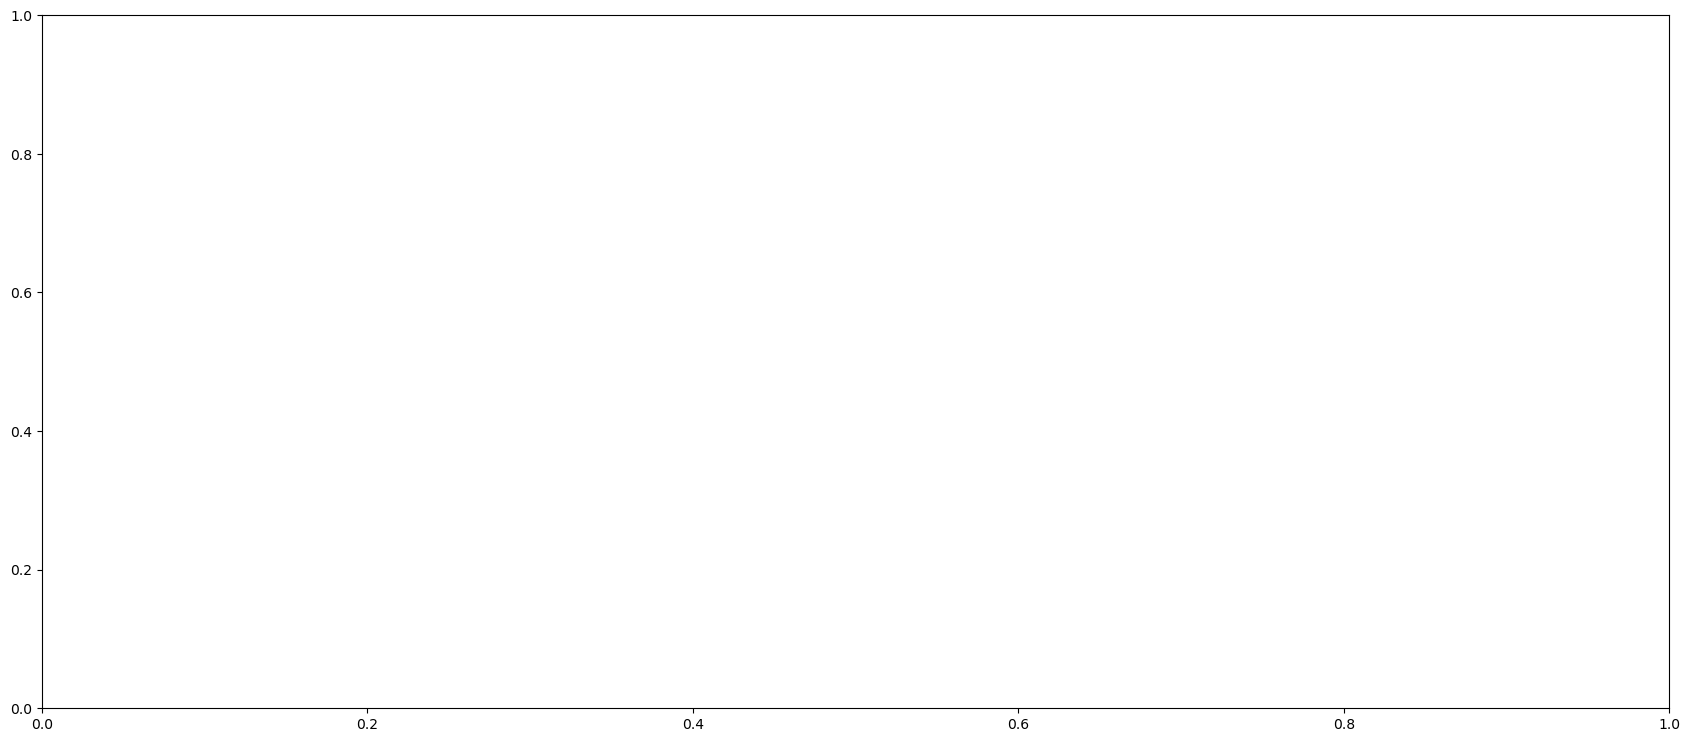

In [28]:
for name, metrics in results.items():
    print(f"Model: {name}")
    print(f"MAE: {metrics['mae']:.4f}")
    print(f"MSE: {metrics['mse']:.4f}")
    print(f"RMSE: {metrics['rmse']:.4f}")
    print(f"Direction: {metrics['direction']:.4f}")

    plt.figure(figsize=(21, 9))
    plt.plot(y_test.index, y_test, label='Actual', marker='o')
    plt.plot(y_test.index, metrics['y_pred_test'], label='Predicted', marker='x')
    plt.xlabel('Date')
    plt.ylabel('^GSPC_log_return')
    plt.title(f'Actual vs Predicted ^GSPC_log_return ({name})')
    plt.legend()
    plt.show()

# Trading

Strategy
- Position (Buy/Sell/do nothing) base on predicted '(log)return' of the next day
    - return > 0 : buy
    - return = 0 : do nothing
    - return < 0 : sell
- buy/sell all of portfolio in each transaction
- no short position

In [ ]:
df_trading = pd.DataFrame() # on test set
df_trading['^GSPC_log_return'] = y_test

for model_name in models:
    pred_log_return = results[model_name]['y_pred_test']
    position = ( pred_log_return > 0 ) # 1: Buy, 0: Sell
    model_log_return = position * df_trading['^GSPC_log_return']
    df_trading[model_name + '_log_return'] = model_log_return

df_trading

In [ ]:
df_trading.index = pd.to_datetime(df_trading.index)

total_days = (df_trading.index[-1] - df_trading.index[0]).days
years = total_days // 365
months = (total_days % 365) // 30

In [ ]:
buy_and_hold_total_return = np.exp(y_test.sum())

print(f'Total(Gross) Return ({years} years {months} months)')
print('----------')
print(f'Buy & Hold (since {(df_trading.index[0]).date()}): {buy_and_hold_total_return *100:.2f}%')
for model_name in models:
    total_return = np.exp(df_trading[model_name + '_log_return'].sum())
    print(f'{model_name}: {total_return *100:.2f}%')

print(f'\nNet Return ({years} years {months} months)')
print('----------')
print(f'Buy & Hold (since {(df_trading.index[0]).date()}): {(buy_and_hold_total_return-1) *100:.2f}%')
for model_name in models:
    total_return = np.exp(df_trading[model_name + '_log_return'].sum())
    print(f'{model_name}: {(total_return-1) *100:.2f}%')

print(f'\nNet Return (per year)')
print('----------')
print(f'Buy & Hold (since {(df_trading.index[0]).date()}): {(buy_and_hold_total_return-1)/total_days*365 *100:.2f}%')
for model_name in models:
    total_return = np.exp(df_trading[model_name + '_log_return'].sum())
    print(f'{model_name}: {(total_return-1)/total_days*365 *100:.2f}%')